**Make a simple model of learned PWMs**

The model predicts log(K27act counts +1) from ATAC at sequence resolution and sequence

In [1]:
# load in relevant packages
import change_path
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


import tf_memory_limit
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle
from keras.models import Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda 
from keras.layers import Dropout, Activation, Concatenate, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from colour import Color
from livelossplot import PlotLossesKeras
import lasso
import training_tools
import shutil
from keras.losses import mae
import evaluation_tools


import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

['', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/home/kal/VENV/lib/python3.5/site-packages/', '/home/kal/VENV/lib64/python3.5/site-packages/', '/home/kal/VENV/lib/python3.5/site-packages/IPython/extensions/', '/home/kal/K27act_models/bin/', '/home/kal/TF_models/bin/', '/home/kal/.ipython']


Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))
/home/kal/K27act_models/bin/atacseq.py:280: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


160363 training samples
3413 testing samples
3414 validation samples


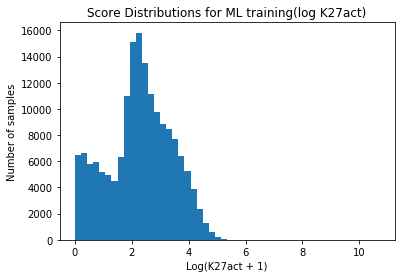

In [2]:
# load in data

#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac k27act nucs'.split() 
peaks['score'] = np.log(peaks['k27act'] + 1)

# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))
num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))
num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

# make a histogram of score
plt.hist(peaks['score'], bins=50)
plt.title('Score Distributions for ML training(log K27act)')
plt.ylabel('Number of samples')
plt.xlabel('Log(K27act + 1)')
plt.show()

In [3]:
def make_pwm_model(get_grads=False, atac_only=False, seq_only=False, batch_size=32, args=[]):
    # model's input
    if atac_only:
         seqs = Input(batch_shape=(batch_size, 1024, 1), name='input_seqs')
    elif seq_only:
        seqs = Input(batch_shape=(batch_size, 1024, 4), name='input_seqs')
    else:
        seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
    num_outputs=1

    #build custom functions
    def add_RC(x):
        if atac_only:
            RC = x[:, ::-1, ::-1]
        elif seq_only:
             RC = x[:, ::-1, ::-1]
        else:
            RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][:, :, ::-1]], axis=2)
        return K.concatenate([x, RC], axis=0)
    def add_RC_shape(s):
        return 2*s[0], s[1], s[2]

    # add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
    add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
    conv = Conv1D(512, 16, name='conv_in', padding='same', activation='relu')(add_rc(seqs))
    conv_dropped = Dropout(0.2, name='dropout')(conv)
    fr_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(conv_dropped)

    # we want to get an 'activation amount' for each pwm
    acts = MaxPooling1D(pool_size=1024, name='pool')(fr_conv)
    predictions = Flatten()(Dense(num_outputs, name='linear_combination')(acts))
    
    # build the model
    model = Model(inputs=seqs, outputs=predictions)
    model.summary()
    if get_grads:
        grads = K.gradients(predictions, seqs)[0]
        return model, grads
    return model

We want a series of similar models to compare:
- with lasso
- without lasso

As well as:
- only sequence
- only atac
- both

In [ ]:
out_dir = '/home/kal/K27act_models/pwm_models/'

# full series of models to test

lasso_path = training_tools.train_model(out_dir, make_pwm_model, peaks, 'lasso_loss', use_lasso=True)
mae_path = training_tools.train_model(out_dir, make_pwm_model, peaks, 'mae_loss')

In [ ]:
base = {'Regression':pickle.load(open('/home/kal/K27act_models/regression_models/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}
# keras models
custom_dict = {'loss_with_grad':mae, 'grad_penalty':mae}
folders={'PWM Lasso': '/home/kal/K27act_models/pwm_models/20180803_163524_lasso_loss/final_model.h5', 
         'PWM MAE': '/home/kal/K27act_models/pwm_models/20180803_164937_mae_loss/final_model.h5'}
mls={}
savedirs={}
for key in folders:
    mls[key] = load_model(folders[key], custom_objects=custom_dict)
    savedirs[key] = os.path.dirname(folders[key]) 

In [ ]:
# get test set
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions_cg.bed'
test_peaks = pd.read_table(peaks_path)
test_peaks['score'] = np.nan

test_peaks = test_peaks[(test_peaks.chr == 'chr8') & (test_peaks.index%2 == 1)]
cutoff = len(test_peaks)//32
test_peaks=test_peaks[:cutoff*32]
print(len(test_peaks))

In [ ]:
import importlib
importlib.reload(evaluation_tools)

In [ ]:
d = evaluation_tools.compare_models(test_peaks, kbaselines=base, logkmls=mls, save_dir=savedirs)

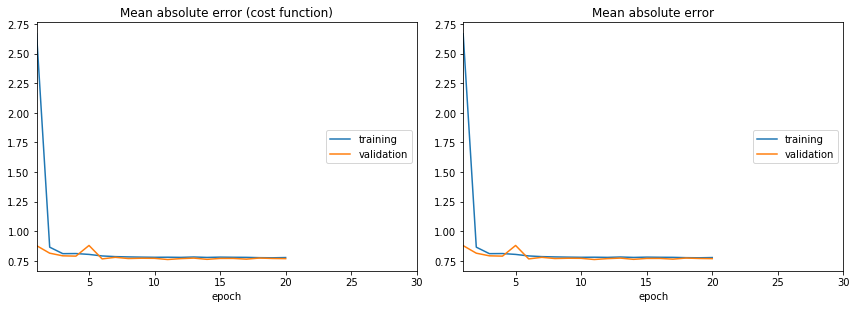

Model moved to /home/kal/K27act_models/pwm_models/20180807_111901_atac_only
160363 training samples
3413 testing samples
3414 validation samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_seqs (InputLayer)      (32, 1024, 5)             0         
_________________________________________________________________
add_rc (Lambda)              (64, 1024, 5)             0         
_________________________________________________________________
conv_in (Conv1D)             (64, 1024, 512)           41472     
_________________________________________________________________
dropout (Dropout)            (64, 1024, 512)           0         
_________________________________________________________________
stack_fr (Lambda)            (32, 1024, 1024)          0         
_________________________________________________________________
pool (MaxPooling1D)          (32, 1, 1024)             0       

ResourceExhaustedError: OOM when allocating tensor with shape[32,1024,1024,1]
	 [[Node: training_2/Adam/gradients/pool_2/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@pool_2/MaxPool"], data_format="NHWC", ksize=[1, 1024, 1, 1], padding="VALID", strides=[1, 1024, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](pool_2/ExpandDims, pool_2/MaxPool, training_2/Adam/gradients/pool_2/Squeeze_grad/Reshape)]]

Caused by op 'training_2/Adam/gradients/pool_2/MaxPool_grad/MaxPoolGrad', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/thouis/VENV/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/thouis/VENV/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/thouis/VENV/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/thouis/VENV/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/thouis/VENV/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/thouis/VENV/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/thouis/VENV/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/thouis/VENV/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/thouis/VENV/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/thouis/VENV/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2827, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/thouis/VENV/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-727ae183aed6>", line 8, in <module>
    training_tools.train_model(out_dir, make_pwm_model, peaks, 'both', patience=3)
  File "/home/kal/K27act_models/bin/training_tools.py", line 100, in train_model
    callbacks=callbacks, validation_data=val_gen, validation_steps=spve, verbose=2)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/engine/training.py", line 2080, in fit_generator
    self._make_train_function()
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/engine/training.py", line 992, in _make_train_function
    loss=self.total_loss)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/optimizers.py", line 445, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/optimizers.py", line 78, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2519, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 581, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 353, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 581, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/nn_grad.py", line 555, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 3083, in _max_pool_grad
    data_format=data_format, name=name)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

...which was originally created as op 'pool_2/MaxPool', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 19 identical lines from previous traceback]
  File "<ipython-input-5-727ae183aed6>", line 8, in <module>
    training_tools.train_model(out_dir, make_pwm_model, peaks, 'both', patience=3)
  File "/home/kal/K27act_models/bin/training_tools.py", line 80, in train_model
    model = model_function(atac_only=atac_only, seq_only=seq_only, batch_size=batch_size, args=args)
  File "<ipython-input-3-20eff69bcc31>", line 31, in make_pwm_model
    acts = MaxPooling1D(pool_size=1024, name='pool')(fr_conv)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/layers/pooling.py", line 46, in call
    data_format='channels_last')
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/layers/pooling.py", line 83, in _pooling_function
    padding, data_format, pool_mode='max')
  File "/home/kal/VENV/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 3663, in pool2d
    data_format=tf_data_format)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1958, in max_pool
    name=name)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 2806, in _max_pool
    data_format=data_format, name=name)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/kal/VENV/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,1024,1024,1]
	 [[Node: training_2/Adam/gradients/pool_2/MaxPool_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, _class=["loc:@pool_2/MaxPool"], data_format="NHWC", ksize=[1, 1024, 1, 1], padding="VALID", strides=[1, 1024, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](pool_2/ExpandDims, pool_2/MaxPool, training_2/Adam/gradients/pool_2/Squeeze_grad/Reshape)]]


In [5]:
out_dir = '/home/kal/K27act_models/pwm_models/'
%matplotlib inline

# full series of models to test

#training_tools.train_model(out_dir, make_pwm_model, peaks, 'seq_only', seq_only=True)
training_tools.train_model(out_dir, make_pwm_model, peaks, 'atac_only', atac_only=True, patience=3)
training_tools.train_model(out_dir, make_pwm_model, peaks, 'both', patience=3)

In [ ]:
folders={'Both': '/home/kal/K27act_models/pwm_models/20180803_164937_mae_loss/final_model.h5', 
         'ATAC Only': '/home/kal/K27act_models/pwm_models/20180806_111439_atac_only/final_model.h5', 
        'Seq Only': '/home/kal/K27act_models/pwm_models/20180806_103757_seq_only/final_model.h5'}
mls={}
savedirs={}
for key in folders:
    mls[key] = load_model(folders[key], custom_objects=custom_dict)
    savedirs[key] = os.path.dirname(folders[key]) 

In [ ]:
d = evaluation_tools.compare_models(test_peaks, kbaselines=base, logkmls=mls, save_dir=savedirs)

In [ ]:
plt.hexbin(d[''])

In [ ]:
def make_dpwm_model(get_grads=False, atac_only=False, seq_only=False, batch_size=32, args=[]):
    # model's input
    if len(args) != 0:
        dropout_rate=args[0]
    else:
        dropout_rate=0
    if atac_only:
         seqs = Input(batch_shape=(batch_size, 1024, 1), name='input_seqs')
    elif seq_only:
        seqs = Input(batch_shape=(batch_size, 1024, 4), name='input_seqs')
    else:
        seqs = Input(batch_shape=(batch_size, 1024, 5), name='input_seqs')
    num_outputs=1

    #build custom functions
    def add_RC(x):
        if atac_only:
            RC = x[:, ::-1, ::-1]
        elif seq_only:
             RC = x[:, ::-1, ::-1]
        else:
            RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
        return K.concatenate([x, RC], axis=0)
    def add_RC_shape(s):
        return 2*s[0], s[1], s[2]

    # add the rc, do a convolution w/o activation and combine down then take concat activation across forward and reverse
    add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
    conv = Conv1D(512, 16, name='conv_in', padding='same', activation=None)(add_rc(seqs))
    conv_dropped = Dropout(dropout_rate, name='dropout')(conv)
    #combined = Dense(64, activation='relu')(conv_dropped)
    fr_conv = Lambda(lambda x: K.concatenate([x[:x.shape[0]//2, :, :], x[x.shape[0]//2:, ::-1, :]], axis=2), 
                       name='stack_fr', output_shape=lambda s: (s[0] // 2, s[1], s[2] * 2))(conv_dropped)

    # we want to get an 'activation amount' for each pwm
    acts = MaxPooling1D(pool_size=1024, name='pool')(fr_conv)
    predictions = Flatten()(Dense(num_outputs, name='linear_combination')(acts))
    
    # build the model
    model = Model(inputs=seqs, outputs=predictions)
    model.summary()
    if get_grads:
        grads = K.gradients(predictions, seqs)[0]
        return model, grads
    return model

In [ ]:
# try with normal dropout at differnt levels
out_dir = '/home/kal/K27act_models/pwm_models/'
%matplotlib inline

training_tools.train_model(out_dir, make_dpwm_model, peaks, 'dropout_20', use_lasso=True, args=[0.2])
training_tools.train_model(out_dir, make_dpwm_model, peaks, 'dropout_00', use_lasso=True, args=[0])
training_tools.train_model(out_dir, make_dpwm_model, peaks, 'dropout_50', use_lasso=True, args=[0.5])

In [ ]:
custom_dict = {'loss_with_grad':mae, 'grad_penalty':mae}
base = {'Regression':pickle.load(open('/home/kal/K27act_models/regression_models/cg_cpg_atac_regression_k27act_norm.pk', 'rb'))}

folders={'Spacial': '/home/kal/K27act_models/pwm_models/20180801_183314_lasso_loss/final_model.h5', 
         '0': '/home/kal/K27act_models/pwm_models/20180802_142329_dropout_00/final_model.h5', 
        '0.2': '/home/kal/K27act_models/pwm_models/20180802_141300_dropout_20/final_model.h5', 
        '0.5': '/home/kal/K27act_models/pwm_models/20180802_144257_dropout_50/final_model.h5'}
mls={}
savedirs={}
for key in folders:
    mls[key] = load_model(folders[key], custom_objects=custom_dict)
    savedirs[key] = os.path.dirname(folders[key]) 

In [ ]:
d = evaluation_tools.compare_models(test_peaks, kbaselines=base, logkmls=mls, save_dir=savedirs)